Yiting Wang 4646909520

(a)

In [105]:
import warnings
warnings.filterwarnings("ignore")

In [293]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

(b)

In [294]:
#Extract the class birds 
import numpy as np
train_bird_index = np.where(y_train[:]==2)[0]

#construct X_train, y_train, X_test, y_test, X_data
X_train = X_train[train_bird_index,::]
y_train = y_train[train_bird_index,::]
print('Number of Training Instances:', X_train.shape[0])

test_bird_index = (np.where(y_test[:]==2)[0])
X_test = X_test[test_bird_index,::]
y_test = y_test[test_bird_index,::]
print('Number of Testing Instances:', X_test.shape[0])

X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((y_train, y_test), axis=0)

Number of Training Instances: 5000
Number of Testing Instances: 1000


First 10 images in the dataset:


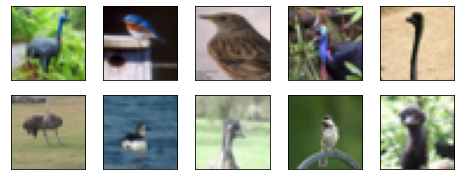

In [4]:
import matplotlib.pyplot as plt
print('First 10 images in the dataset:')
fig = plt.figure(figsize=(8, 3))
for i in range(0, 10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plt.imshow(X_data[i])
plt.show()

(c)

In [108]:
ratio = 0.8
total_pixel = X_data.shape[0] * X_data.shape[1] * X_data.shape[2]
num_random = int(total_pixel * ratio)

linear_idx = np.random.choice(total_pixel, num_random)
img_idx = [idx // 1024 for idx in linear_idx]
row_idx = [idx % 1024 // 32 for idx in linear_idx]
col_idx = [idx % 1024 % 32 for idx in linear_idx]
pix_idx = (img_idx, row_idx, col_idx)
select_pixel = X_data[pix_idx]

In [109]:
X_bird = X_data.reshape(total_pixel, X_data.shape[3])
print('Total Pixels:', X_bird.shape)

Total Pixels: (6144000, 3)


(d)

In [227]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters = 4, random_state = 0).fit(select_pixel)
#kmeans_model = KMeans(n_clusters = 24, random_state = 0).fit(select_pixel)

In [111]:
kcolor_birds = X_data.reshape(-1,3)
color_pred = k_means.predict(kcolor_birds)
for i in range(kcolor_birds.shape[0]):
    kcolor_birds[i] = np.copy(k_means.cluster_centers_[color_pred[i]])

kcolor_birds = np.reshape(kcolor_birds, X_data.shape)
print(kcolor_birds.shape)

(6000, 32, 32, 3)


(e)

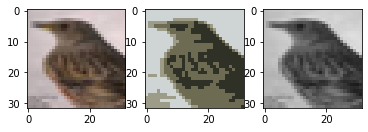

In [295]:
#Construct grayscale data
from skimage.color import rgb2gray
gray_birds = np.expand_dims(rgb2gray(X_data), axis=-1)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(X_data[2])
axes[1].imshow(kcolor_birds[2])
axes[2].imshow(np.stack((gray_birds[2, :, :, 0], )*3, axis = -1), cmap = 'gray')
plt.show()

(f)

In [284]:
#Construct grey_X_train, grey_X_test
train_num = 5000
grey_X_train = gray_birds[:train_num]
grey_X_test = gray_birds[train_num:]
grey_X_train /= 255
grey_X_test /= 255

#Construct grey_y_train, grey_y_test
from keras.utils import np_utils
color_onehot = np_utils.to_categorical(color_pred)
color_onehot = color_onehot.reshape((6000, 4096))
grey_y_train = color_onehot[:train_num].reshape((-1, 4096))
grey_y_test = color_onehot[train_num:].reshape((-1, 4096))

In [220]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D
model = Sequential()

#Convolutional layers
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', 
                 input_shape = (32,32,1), activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Dropout(0.25))

# MLP layers
model.add(Flatten())
model.add(Dense(8192, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation = 'relu'))
model.add(Activation('softmax'))

In [155]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

In [171]:
#Set optimization and callbacks
from keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
test_error = []
class New_callback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        #Record test error
        scores = self.model.evaluate(grey_X_test, grey_y_test, verbose = 1)
        test_error.append(scores)
        checkpointer = ModelCheckpoint(filepath = 'CNNcheckpoints\weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                monitor = 'val_loss', mode = 'min', verbose = 0, save_best_only = True)
        #[New_callback()]

In [172]:
#Fit the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
cnn = model.fit(grey_X_train, grey_y_train,
                epochs = 30, verbose = 1, batch_size = 128, shuffle = True,
                validation_split = 0.2, callbacks = [New_callback()])

Epoch 1/30
36/36 [==============================] - 33s 917ms/step - loss: 0.5796 - val_loss: 0.5633
Epoch 2/30
36/36 [==============================] - 33s 927ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 3/30
36/36 [==============================] - 34s 939ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 4/30
36/36 [==============================] - 34s 938ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 5/30
36/36 [==============================] - 34s 942ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 6/30
36/36 [==============================] - 35s 973ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 7/30
36/36 [==============================] - 36s 990ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 8/30
36/36 [==============================] - 34s 951ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 9/30
36/36 [==============================] - 34s 956ms/step - loss: 0.5633 - val_loss: 0.5633
Epoch 10/30
36/36 [==============================] - 34s 947ms/step - loss: 0.5633 - val_lo

In [179]:
#Epoch, Train Error and Test Error
import pandas as pd 
epoch, test_error_5 = [], []
train_error = cnn.history['loss']
valid_loss = cnn.history['val_loss']

for i in range(30):
    epoch.append(int(i + 1))
    test_error_5.append(test_error[i]*5)
        
Epoch = pd.DataFrame(epoch, columns = ['Epoch'])
Train_error  = pd.DataFrame(train_error, columns = ['Train Error'])
Valid_loss = pd.DataFrame(valid_loss, columns = ['Valid Loss'])
Test_error = pd.DataFrame(test_error, columns = ['Test Error'])

table = pd.concat([Epoch, Train_error, Valid_loss, Test_error], axis = 1)
print(table)

    Epoch  Train Error  Valid Loss  Test Error
0       1     0.579578    0.563262    0.563262
1       2     0.563264    0.563263    0.563263
2       3     0.563263    0.563263    0.563263
3       4     0.563265    0.563263    0.563263
4       5     0.563266    0.563262    0.563260
5       6     0.563266    0.563263    0.563263
6       7     0.563263    0.563263    0.563263
7       8     0.563263    0.563263    0.563263
8       9     0.563263    0.563263    0.563263
9      10     0.563275    0.563319    0.563313
10     11     0.563317    0.563319    0.563313
11     12     0.563317    0.563319    0.563313
12     13     0.563317    0.563319    0.563313
13     14     0.563317    0.563319    0.563313
14     15     0.563317    0.563319    0.563313
15     16     0.563317    0.563319    0.563313
16     17     0.563317    0.563319    0.563313
17     18     0.563317    0.563319    0.563313
18     19     0.563317    0.563319    0.563313
19     20     0.563317    0.563319    0.563313
20     21    

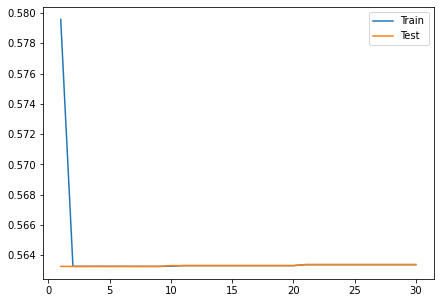

In [226]:
#Plot loss curves
fig, axes = plt.subplots(figsize=(7, 5))
axes.plot(range(1, 31), Train_error, label = 'Train')
#axes.plot(range(1, 31), Valid_loss, label = 'Validation')
axes.plot(range(1, 31), Test_error, label = 'Test')
axes.legend()
plt.show()

In [271]:
kmeans_model = KMeans(n_clusters = 24).fit(select_pixel)

In [313]:
y_pred_cnn = model.predict(grey_X_test[:10])
y_pred_cnn = np.reshape(y_pred_cnn, (10, 32, 32, 4))
y_pred_cnn = np.argmax(y_pred_cnn, axis = -1)
y_pred_cnn = k_means.cluster_centers_[y_pred_cnn]

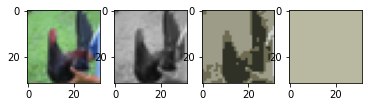

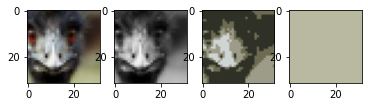

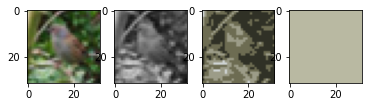

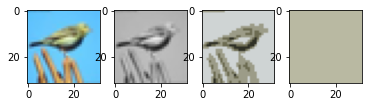

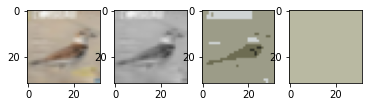

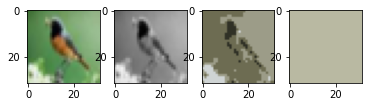

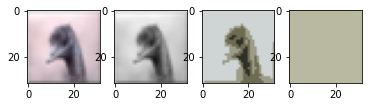

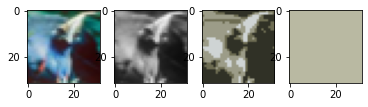

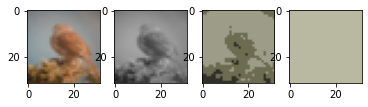

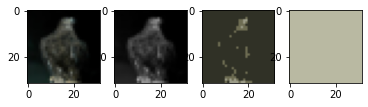

In [320]:
for i in range(10):
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(X_data[train_num + i])
    axes[1].imshow(np.stack((gray_birds[train_num + i, :, :, 0],)*3, axis = -1), cmap = 'gray')
    axes[2].imshow(kcolor_birds[train_num + i])
    axes[3].imshow(y_pred_cnn[i]/215)
    plt.show()

According to the results, train error is a little bit higher than test errors. Train error first decreases and then increases sightly. Test errors increases sightly. We found that after 10 epoches, the errors kept still and then changed suddenly as steps. So 10 epoches are enough for the model. We compare the images, I found the the images did not have distinct colors. It was worse than other images becasue the deeping learning depends on the variables.